In [1]:
from typing import List
import torch
from torch import nn, optim
from MRL import Matryoshka_CE_Loss, MRL_Linear_Layer
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)


In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

        self.encoder_mrl = MRL_Linear_Layer([5, 10], 10)

        self.decoder_mrl = nn.Linear(10, 18)


    def forward(self, x):
        encoded = self.encoder(x)
        mrl_encoded = self.encoder_mrl(encoded)
        first = mrl_encoded[-1]
        second = mrl_encoded[0]
        decoded = self.decoder_mrl(first)
        decoded = self.decoder(decoded)
        return decoded, first, second, mrl_encoded

In [4]:
model = autoencoder()
loss_function = nn.BCELoss()
clf_loss_function = Matryoshka_CE_Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
  (encoder_mrl): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=5, out_features=10, bias=True)
    (nesting_classifier_1): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder_mrl): Linear(in_features=10, out_features=18, bias=True)
)

In [8]:
for epoch in range(epochs):
    for images, labels in loader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        reconstructed, first, second, mrl_logits = model(images)
        clf_loss = clf_loss_function(mrl_logits, labels)

        optimizer.zero_grad()
        clf_loss.backward()
        optimizer.step()

        losses.append(clf_loss.item())
    outputs.append((epoch, images, mrl_logits, labels))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {clf_loss.item():.6f}")

Epoch 1/20, Loss: 0.001362
Epoch 2/20, Loss: 0.000438
Epoch 3/20, Loss: 0.000698
Epoch 4/20, Loss: 0.000592
Epoch 5/20, Loss: 0.006267
Epoch 6/20, Loss: 0.008338
Epoch 7/20, Loss: 0.004117
Epoch 8/20, Loss: 0.000144
Epoch 9/20, Loss: 0.000131
Epoch 10/20, Loss: 0.000387
Epoch 11/20, Loss: 0.007437
Epoch 12/20, Loss: 0.000188
Epoch 13/20, Loss: 0.013176
Epoch 14/20, Loss: 0.001239
Epoch 15/20, Loss: 0.000577
Epoch 16/20, Loss: 0.000101
Epoch 17/20, Loss: 0.000932
Epoch 18/20, Loss: 0.000077
Epoch 19/20, Loss: 0.007592
Epoch 20/20, Loss: 0.000260


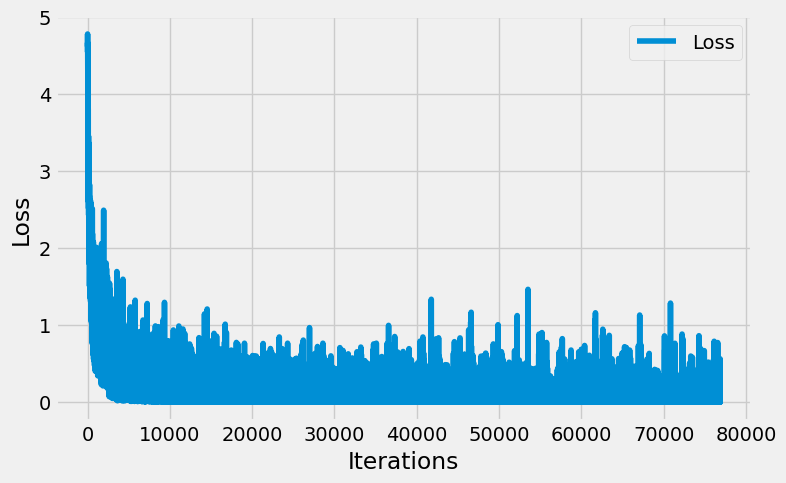

In [9]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

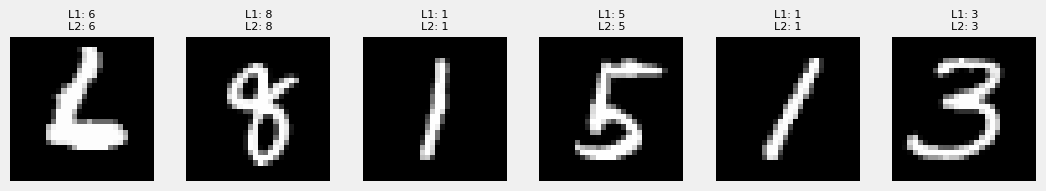

In [31]:
from random import randint
idx = randint(0, len(outputs) - 1)
output_tuple = outputs[idx]
if len(output_tuple) == 4:
    epoch_idx, original_imgs, mrl_logits, labels = output_tuple
elif len(output_tuple) == 3:
    epoch_idx, original_imgs, mrl_logits = output_tuple
    labels = None
else:
    raise ValueError(f"Unexpected tuple length in outputs: {len(output_tuple)}")
n = min(6, original_imgs.size(0))  

original_imgs = original_imgs[:n].detach().cpu().view(-1, 28, 28)


preds = [torch.argmax(logits[:n], dim=1).cpu() for logits in mrl_logits]


plt.figure(figsize=(1.8 * n, 2))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.imshow(original_imgs[i], cmap='gray')
    ax.axis('off')

    
    pred_text = "\n".join([f"L{i+1}: {preds[i][j].item()}" for i, j in enumerate([i]*len(preds))])
    ax.set_title(pred_text, fontsize=8)

plt.tight_layout()
plt.show()


In [12]:
torch.save(model.state_dict(), "../output/autoencoder_sub_weights.pth")
torch.save(model, "../output/autoencoder_sub_weights.pth")
print("Saved")

Saved
